In [1]:
import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
%run data_gen.ipynb

In [2]:

filename = "data/news.txt"

vocabulary = tf.compat.as_str(open(filename, encoding='utf8').read()[:1000_000]).split()
vocab = list(set(vocabulary))


# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = len(vocab)
print('Data size', len(vocabulary), ' Vocab Size', vocabulary_size)

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary



Data size 202929  Vocab Size 44346


In [3]:
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0



Most common words (+UNK) [['UNK', 1], ('*', 12625), ('ነው', 3070), ('#', 1975), ('ላይ', 1908)]
Sample data [2575, 2854, 1419, 10063, 1625, 10064, 3627, 352, 862, 247] ['ጋዜጠኛ', 'ተመስገን', 'ደሳለኝ', 'በጠበቃው', 'በአቶ', 'አምሐ', 'መኮንን', 'አማካይነት', 'በፌዴራል', 'ጠቅላይ']


In [4]:

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
#     batch_size = batch_size // 2
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(
        maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
            
#     sim_batch = np.zeros_like(batch)
#     sim_labels = np.zeros_like(labels)
#     for b_i in range(len(batch)):
#         b = batch[b_i]
#         sim = sim_data[b]
#         sim_context = np.random.choice(sim, 2)
#         for sim_word in sim_context:
#             sim_batch[b_i] = b
#             sim_labels[b_i, 0] = sim_word
    
#     for sim_i in range(len(sim_batch)):
#         rev_word = reverse_dictionary[sim_batch[sim_i]]
#         rev_label = reverse_dictionary[sim_labels[sim_i, 0]]
#     batch = np.hstack((batch, sim_batch))
#     labels = np.vstack((labels, sim_labels))
        
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=2)
for i in range(len(batch)):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
          reverse_dictionary[labels[i, 0]])

# Step 4: Build and train a skip-gram model.


1419 ደሳለኝ -> 10063 በጠበቃው
1419 ደሳለኝ -> 2575 ጋዜጠኛ
10063 በጠበቃው -> 1419 ደሳለኝ
10063 በጠበቃው -> 10064 አምሐ
1625 በአቶ -> 3627 መኮንን
1625 በአቶ -> 1419 ደሳለኝ
10064 አምሐ -> 10063 በጠበቃው
10064 አምሐ -> 1625 በአቶ


In [5]:
dg = DataGen()  

In [6]:

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.
n_features = dg.n_vowel + dg.n_consonant
n_features = len(dg.char2int)
n_chars = 11
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
np.random.seed(1000)
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
print(valid_examples[:10])


[88  4 62 63 48 85 73 84 39 47]


In [7]:
def look2vec(batch, label=False):
    vecs = np.ndarray(shape=(batch_size, n_chars, n_features), dtype=np.float32)
    for i in range(len(batch)):
        b = batch[i]
        w = reverse_dictionary[b]
        if not label:
            w = '&' + w[:-1]
        vec = dg.word2vec2(w)
        vecs[i] = vec
    return vecs  

In [8]:

graph = tf.Graph()

with graph.as_default():

    # Input data.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        
        sim_train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        sim_train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        
        lstm_inputs = tf.placeholder(tf.float32, shape=[batch_size, n_chars, n_features], name="lstm_input")
        lstm_outputs = tf.placeholder(tf.float32, shape=[batch_size, n_chars, n_features], name="lstm_output")
        
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        with tf.name_scope('nce_weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [vocabulary_size, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
            
    with tf.device('/gpu:0'):
        with tf.name_scope('lstm'):
            lstm_w = tf.Variable(
                tf.truncated_normal(
                    [embedding_size, n_features],
                    stddev=1.0 / math.sqrt(embedding_size)))
            lstm_b = tf.Variable(tf.zeros([n_features]))
#             lstm = tf.contrib.rnn.BasicLSTMCell(num_units=embedding_size, state_is_tuple=True)
#             initial_state = tf.nn.rnn_cell.LSTMStateTuple(embed, embed)
            initial_state = embed
#             loutputs, state = tf.nn.dynamic_rnn(cell=lstm, 
#                                                inputs=lstm_inputs, 
#                                                initial_state=initial_state, 
#                                                time_major=False, 
#                                                dtype=tf.float32)
            lstm = tf.contrib.rnn.GRUCell(num_units=embedding_size)
            loutputs, state = tf.nn.dynamic_rnn(cell=lstm, 
                                               inputs=lstm_inputs, 
                                               initial_state=initial_state, 
                                               time_major=False, 
                                               dtype=tf.float32)
            
            flatOutputs = tf.reshape(loutputs, [-1, embedding_size])
            lstm_label = tf.reshape(lstm_outputs, [-1, n_features])
#             logits2 = tf.matmul(flatOutputs, lstm_w) + lstm_b
    
            logits2 = tf.layers.dense(flatOutputs, n_features, activation=tf.nn.relu)
            loss2 = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits2, labels=lstm_label)
            loss2 = tf.reshape(loss2, [batch_size, -1])
            loss2 = tf.reduce_mean(loss2)
            softmax2 = tf.nn.softmax(logits2)
            y2 = tf.argmax(softmax2, 1)
            y2 =  tf.reshape(y2, [batch_size, -1])

            train_step = tf.train.AdamOptimizer(.001).minimize(loss2)
            
            correct_pred2 = tf.equal(tf.argmax(logits2, 1), tf.argmax(lstm_label, 1))
            correct_pred2 = tf.cast(correct_pred2, tf.float32)
            accuracy2 = tf.reduce_mean(correct_pred2)

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))

    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()


In [9]:

# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter('./log', session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    average_acc = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                    skip_window)
        tt = look2vec(batch_inputs)
        ty = look2vec(batch_inputs, label=True)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels, lstm_inputs: tt, lstm_outputs: ty}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard.
        _, summary, loss_val, _t, acc2 = session.run(
            [optimizer, merged, loss, train_step, accuracy2],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val
        average_acc += acc2
#         tt = look2vec(batch_inputs)
#         ty = look2vec(batch_labels.flatten())
#         print(ty.shape, ty.dtype)
#         feed_dict2 = {lstm_inputs: tt, lstm_outputs: ty}
        
#         _, loss2, acc2 = session.run(
#         [train_step, loss, accuracy],
#             feed_dict=feed_dict2
#         )
#         print("Loss : {0}, Acc : {1}".format(loss2, acc2))

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                average_acc /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            print(average_acc)
            average_acc = 0
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

    # Write corresponding labels for the embeddings.
    with open('./log/metadata.tsv', 'w', encoding='utf8') as f:
        for i in xrange(vocabulary_size):
            f.write(reverse_dictionary[i] + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join('./log', 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join('./log', 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

writer.close()


Initialized
Average loss at step  0 :  257.61004638671875
0.0
Nearest to በተለይ: ማለትም, የተሰራጨው, ሙሉነት, በተሰጣቸውና, የተገበረበትና, ባይፈለግም, የተሠሩት, ሊሆኑላቸው,
Nearest to ላይ: የሚጨነቅ, አሳፋሪ, እየተዘነጉ, ማዳበሪያ, ማደግም, ከፍዬ, አልተቀበሉም, የአሥረኛ,
Nearest to መካከል: እንዲጠናቀቅ, ሕሊናቸውን, ንድፊያ, እያመነጨች, ሰፊ, ጤናማ, በመታመኑ, የሞቱበት,
Nearest to ፓርቲዎች: ፋራህ, እኩለለሊት, መነሻን, በተባባሰ, ቴክኖሎጂ, የመፈሳፈስ, ደገፍ, ታደንቃለች,
Nearest to አሁን: እየገነባሁም, መደበላቸው, ከፍዬ, አስተሳሰቦችና, ለሰላማዊ, የከረመው, ባዘዘው, መቀየሪያ,
Nearest to አለበት: ለሳይንስና, በየመንፈቁ, መጫር, ከያዘ, ማይል, ወ/ሪት, የሚጠይቀውን, ተጥሰው,
Nearest to ምክር: ለማስለቀቅ, በሚደረገው, ኒልን, ለቤተ, ለግለሰብና, የፊልሞች, ተንከባክበው, ብሶም,
Nearest to ሳይሆን: የስሜት, በአባላቱ, ያህሉን, አድቫንስድ, እንዳብራሩት, ተመለሰ, አስልተው, ለእነዚሁ,
Nearest to መሆኑን: መርፌ, በሚደፍር, አባትነትን, ቆረጠ, ከ#ኛ, ትላንት, ዋስትናው, መልክና,
Nearest to ችግር: በሚላት, ባላስታውሰውም, እየገረመኝ, መደምደሚያ, የተቋቋም, መሣሪያዎችን, ካለን, የሚጮሁትን,
Nearest to ከ#: ላለመስማማትም, ፍልስፍናዎች, ዶ, አብራው, ሎፔዝ, በሥራዎቻቸው, በሚያብራራው, ተብዬዎች,
Nearest to ሚሊዮን: ዝንባሌም, እንዲመረመሩ, ያለበትመንግሥት, ለምክንያታዊነት, ሰከንዶች, ፊታችሁ, የትችት, አባል,
Nearest to ደረጃ: የሚሳተፉበት, አልተራራቁም, ክሽን, የኢዴፓ, የሙያና, ሊጠቀስ, በደብዳቤው

Average loss at step  52000 :  3.120857632994652
0.9777805393636226
Average loss at step  54000 :  3.0998532844781876
0.9794360793530941
Average loss at step  56000 :  3.041449845790863
0.9798032675981522
Average loss at step  58000 :  3.0288141090869902
0.9794843747019768
Average loss at step  60000 :  2.990612519264221
0.9808124999403953
Nearest to በተለይ: በተከታታይ, ተለይተው, በተለይም, በተለያየ, በ#ም, በተሰጣቸውና, በተሻለ, በተለመደው,
Nearest to ላይ: ላይም, የሚፋጁ, የሚጥሉት, ላመነበት, ከዘጠኝ, ባልፈረሰው, ላጤ, በዋዜማው,
Nearest to መካከል: መመልከት, መገለጹ, መካከልም, መዳኛ, በመካከለችን, ከሩጫው, የሠራሁ, ፍርኃት,
Nearest to ፓርቲዎች: ፓርቲዎችን, ፓርቲን, የሚጠፉበት, የሚመሩዋትን, ደገፍ, የፓርቲው, ሥርዓታችን, መጠቆምና,
Nearest to አሁን: አካላት, አጋጣሚውን, አሜሪካ, አምሳባደሩ, ዕድገቱን, አሁንም, አሉት, ይመሻል,
Nearest to አለበት: አለባቸው, አባተ, አለቃ, አለብን, ለላቀ, አሸባሪነት, የሚያሰልፈው, ማይል,
Nearest to ምክር: ምክንያቱም, ምልክቶች, የድርጊት, ምክንያቱ, በካርቱም, ምድብ, አምደም, የምክር,
Nearest to ሳይሆን: ሳይገባ, የተናገረው, ሳይሆኑ, ሳይባል, ሳይንስ, ሳይለንት, መዋጮና, እንደመሰለው,
Nearest to መሆኑን: መሆኑ, መሆኗን, መወሰኑን, መሆኑንና, መሆኑንም, ባለመቻል, ለእግር, መንሰራፋት,
Nearest to ችግር: ችሎታ, ሲወድም, ሳይ

In [15]:
for v in vocab:
    if 'ይሆን' in v:
        print(v)
print(len(vocab))

እንዳይሆን
እንዳይሆንባቸው
የማይሆንበት
ባይሆንማ
ባይሆንም
እንደማይሆን
ይሆንብኛል
ይሆንሃል
ባይሆን
ሳይሆን
ይሆን
አይሆንበትም
ሳይሆንላቸው
ላይሆን
ይሆንና
አይሆንም
44346


In [17]:
def get_similar_words(emb, word):
    for i in range(10):
        valid_word = reverse_dictionary[i]
        top_k = 8  # number of nearest neighbors
        nearest = (-emb[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = '%s %s,' % (log_str, close_word)
        print(log_str)

get_similar_words(final_embeddings, '')

Nearest to UNK: ያህል, ቢሆንም, ይህንን, ጉዳይ, መሠረት, ተብሎ, ቤት, የ#,
Nearest to *: ቦታ, የሚል, ከተማ, ይገባል, ይህ, በተለይ, ብዙ, ብቻ,
Nearest to ነው: UNK, ሥርዓት, አለ, ብለዋል, አገር, በማለት, እንዲሁም, ወይም,
Nearest to #: ገልጸዋል, ተብሎ, ይገባል, እንደ, ያለ, ያሉ, ሳይሆን, ጋር,
Nearest to ላይ: ሚሊዮን, የሚል, ፓርቲዎች, ከ#, ቦታ, ምን, ቤቱ, ወቅት,
Nearest to ውስጥ: ሳይሆን, እንደሆነ, ይገባል, ወቅት, በተለይ, የፖለቲካ, እስከ, ምክንያት,
Nearest to ግን: ላይ, እንደ, በ#, እንዲሁም, ብለዋል, ሰዎች, ጊዜ, ወይም,
Nearest to ወደ: ቀን, የሚል, እንደ, ማለት, *, ሕግ, አሉ, ብር,
Nearest to አቶ: ያሉ, በአንድ, እንጂ, ቁጥር, ደረጃ, አገር, ነገር, አዲስ,
Nearest to ጋር: በመሆኑ, እስከ, ተብሎ, የሚል, እንጂ, ብዙ, ወይም, ያህል,


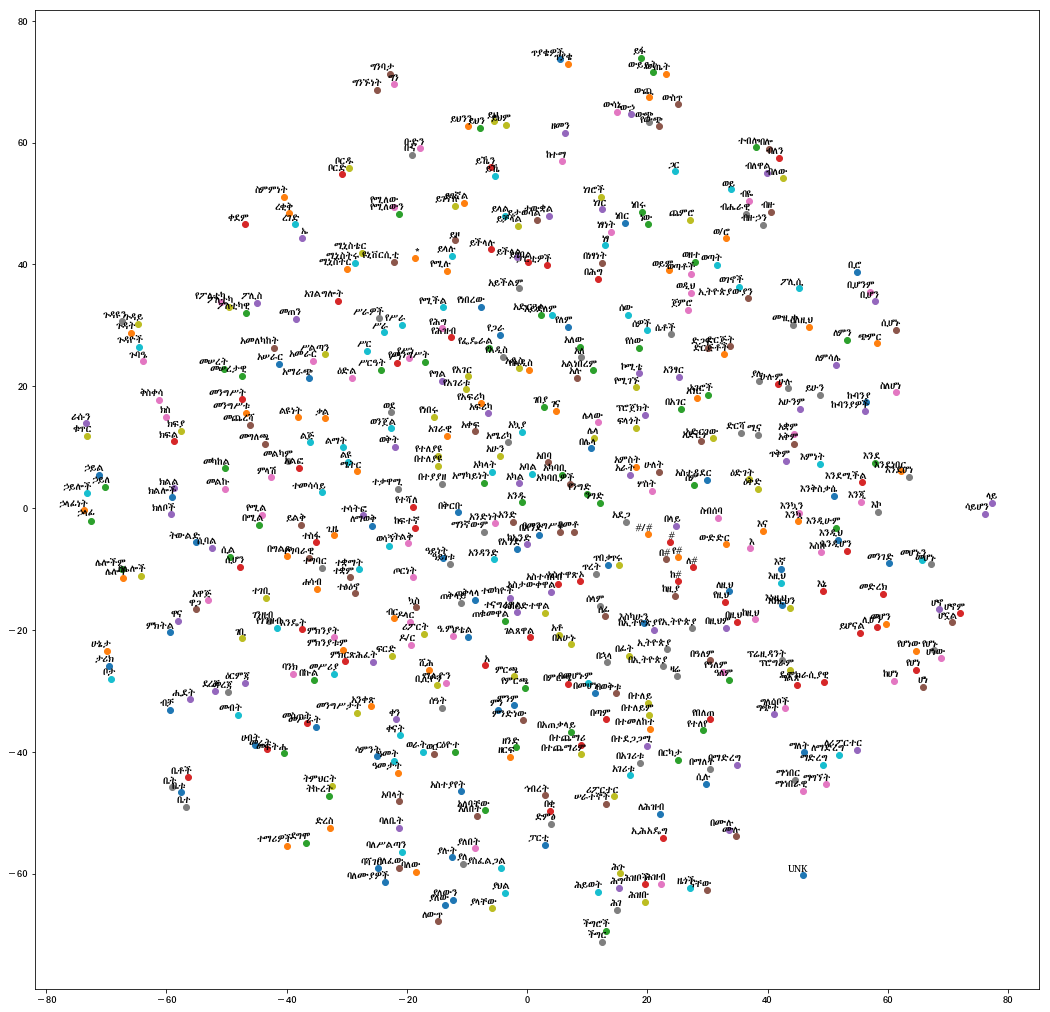

In [18]:

# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.rc('font', family='Abyssinica SIL')
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)


try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, 'tsne.png')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)
